In [4]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model


In [5]:
# read the data from the csv file /home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv

df = pd.read_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index_col=0, parse_dates=True)
df.head()

,open,high,low,close,close_diff_percent,close_moving_avg,std,upper_bb,lower_bb,close_diff,close_scaled_down
DateTime,,,,,,,,,,,
2024-12-31 09:16:00,2355950,2356430,2354005,2355135,NaN,NaN,NaN,NaN,NaN,NaN,2355.135
2024-12-31 09:17:00,2355070,2356150,2354500,2355915,3.311912,NaN,NaN,NaN,NaN,780.0,2355.915
2024-12-31 09:18:00,2355980,2356025,2355100,2355405,-2.164764,NaN,NaN,NaN,NaN,-510.0,2355.405
2024-12-31 09:19:00,2355400,2357195,2355215,2356905,6.368332,NaN,NaN,NaN,NaN,1500.0,2356.905
2024-12-31 09:20:00,2356960,2357015,2355475,2355475,-6.067279,NaN,NaN,NaN,NaN,-1430.0,2355.475


In [6]:
def func_of_arima_1_1_1(t_1_data, t_2_data, ar_param, ma_param, prev_residual):
    """
    Calculate the ARIMA(1,1,1) value based on previous data and parameters.
    
    :param t_1_data: Previous time series data point (t-1)
    :param t_2_data: Previous time series data point (t-2)
    :param ar_param: AR parameter
    :param ma_param: MA parameter
    :param prev_residual: Previous residual
    :return: Computed value for the current time step
    """
    return ar_param * (t_1_data - t_2_data) + ma_param * prev_residual + t_1_data

def func_of_garch_1_1(omega, alpha, beta, prev_volatility, prev_residual):
    """
    Calculate the GARCH(1,1) value based on previous volatility and residuals.
    :param omega: Constant term
    :param alpha: Coefficient for lagged squared residuals
    :param beta: Coefficient for lagged volatility
    :param prev_volatility: Previous volatility
    :param prev_residual: Previous residual
    :return: Computed volatility for the current time step
    """
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)


def forcast_next_minute(_20_minute_data, order_arima=(1, 1, 1), order_garch=(1, 1)):
    """
    Forecast the next minute using ARIMA and ARCH models.
    :param _20_minute_data: DataFrame with 20 minutes of data
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: Forecasted value for the next minute
    """
    # Fit ARIMA model
    arima_model = ARIMA(_20_minute_data, order=order_arima)
    arima_fit = arima_model.fit()
    residual_np = np.array(arima_fit.resid)
    ma_param = arima_fit.maparams[0]
    ar_param = arima_fit.arparams[0]
    
    arima_forecast = func_of_arima_1_1_1(
        t_1_data=_20_minute_data.iloc[-1],
        t_2_data=_20_minute_data.iloc[-2],
        ar_param=ar_param,
        ma_param=ma_param,
        prev_residual=residual_np[-1]
    )

    garch_model = arch_model(residual_np, vol='Garch', p=order_garch[0], q=order_garch[1])
    garch_fit = garch_model.fit(disp="off")

    garch_params = garch_fit.params
    omega = garch_params['omega']
    alpha = garch_params['alpha[1]']
    beta = garch_params['beta[1]']

    vol_garch = garch_fit.conditional_volatility

    forecast_garch = func_of_garch_1_1(
        omega,
        alpha,
        beta,
        vol_garch[-1],
        residual_np[-1]
    )

    return arima_forecast, forecast_garch

In [9]:
def rolling_forecast(df, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1)):
    """
    Perform rolling forecast on the DataFrame.
    :param df: DataFrame with the data
    :param window_size: Size of the rolling window
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: List of forecasted values
    """
    forecasts_mid = []
    forecast_vol = []

    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

    for i in range(window_size, len(df)):
        _20_minute_data = df.iloc[i-window_size:i]
        arima_forecast, garch_forecast = forcast_next_minute(_20_minute_data, order_arima, order_arch)
        forecasts_mid.append(arima_forecast)
        forecast_vol.append(garch_forecast)  # Get the last forecasted varianc
    
    return forecasts_mid, forecast_vol

In [10]:
data = df["close_scaled_down"].loc["2025-02-01":"2025-02-05"]/10
forecasts_mid, forecast_vol = rolling_forecast(data, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1))


/home/vishi/bolinger/.venv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code 

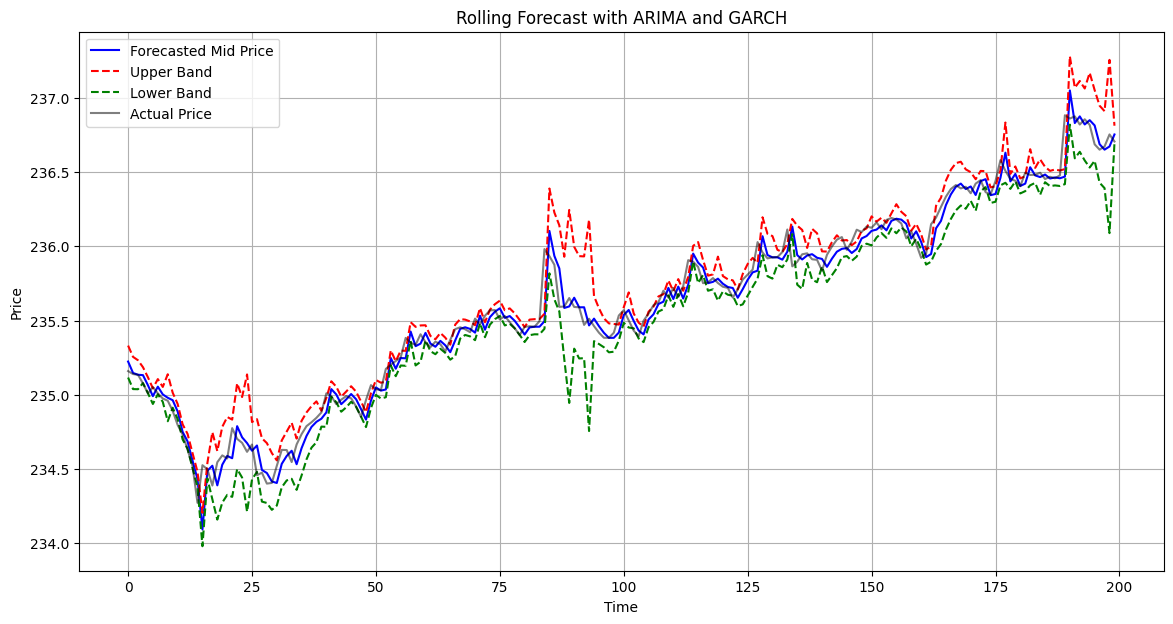

In [22]:
upper_band = np.array(forecasts_mid) + 2 * np.array(forecast_vol)
lower_band = np.array(forecasts_mid) - 2 * np.array(forecast_vol)
plt.figure(figsize=(14, 7))
plt.plot(forecasts_mid[800:1000], label='Forecasted Mid Price', color='blue')
plt.plot(upper_band[800:1000], label='Upper Band', color='red', linestyle='--')
plt.plot(lower_band[800:1000], label='Lower Band', color='green', linestyle='--')

plt.plot(np.array(data.values[820:1020]), label='Actual Price', color='black', alpha=0.5)

plt.legend()
plt.title('Rolling Forecast with ARIMA and GARCH')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid()
plt.show()